# Double DK rumour spreading model


This model uses [graph-tool](https://graph-tool.skewed.de/) to efficiently support graph drawing at scale (~4000 nodes). [Unfortunately, graph tool does not support being installed through pip.](https://graph-tool.skewed.de/installation.html#native-installation)

To run this model, use the following instructions:

1. Install your python environment manager. If you don't have one, we recommend installing micromamba.
2. Set up your environment by running `micromamba env create --name compmodelling-dk -c conda-forge networkx graph-tool ipykernel`. If using conda or mamba, swap out 'micromamba' for the respective environment manager name.
3. Make sure your software reading this .ipynb file is using your compmodelling-dk python version. (Hint: use `which python` while in your environment to see where your python version is located). You may need to reload during this step for your software to recognise the environment.
4. When you're finished with your environment, remove it by running `micromamba env remove compmodelling-dk`.


In [21]:
import networkx as nx
from graph_tool.all import Graph, graph_draw, sfdp_layout, closeness, label_components
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from typing import Self
from IPython.display import clear_output

class State(Enum):
    IGNORANT = 0 # People who haven't encountered the rumour
    RUMOUR_SPREADER = 1 # People actively spreading the rumour
    RUMOUR_CONTAINER = 2 # People who have heard the rumour but are not spreading it
    TRUTH_SPREADER = 3 # People actively spreading the truth
    TRUTH_CONTAINER = 4 # People who have heard the truth but are not spreading it

STATUS_COLOURS = {
    State.IGNORANT: 'blue',
    State.RUMOUR_SPREADER: 'orange',
    State.RUMOUR_CONTAINER: 'red',
    State.TRUTH_SPREADER: 'darkgreen',
    State.TRUTH_CONTAINER: 'lawngreen'
}

TIME_STEPS = 25
POPULATION_SIZE = 4039
CLUSTERING_COEFFICIENT = 44

ACTIVENESS = 0.1
RUMOUR_ACCEPTANCE_PROB = 0.4
TRUTH_ACCEPTANCE_PROB = 0.7

SPREADER_SPREADER_STIFLE_PROB = 0.1
SPREADER_STIFLER_STIFLE_PROB = 0.1

FORGET_PROB = 0.01

In [18]:
class Person:
    def __init__(self: Self) -> None:
        self.state = State.IGNORANT
        self.contacted = []

        self.credibility = np.clip(np.random.normal(0.5, 0.1), 0, 1) # Mean of 0.5, std dev of 0.1, restricted to [0, 1]
        self.conviction = 0.1

    def spread_rumour(self: Self, neighbour: list) -> None:
        # Checks the nodes are active and haven't already contacted each other
        if neighbour in self.contacted:
            return
        if np.random.random() > ACTIVENESS:
            return

        # Add each other to the contacted list so they don't contact each other again this time step
        self.contacted.append(neighbour)
        neighbour.contacted.append(self)

        # If neighbour is ignorant
        if neighbour.state == State.IGNORANT:
            convincing_power = self.credibility * RUMOUR_ACCEPTANCE_PROB
            resistance = neighbour.conviction
            conversion_prob = convincing_power / (convincing_power + resistance)
            if np.random.random() < conversion_prob:
                neighbour.state = State.RUMOUR_SPREADER
                neighbour.conviction = conversion_prob
        # If neighbour is a spreader
        elif neighbour.state == State.RUMOUR_SPREADER:
            self.conviction += (1 - self.conviction) * neighbour.credibility
            neighbour.conviction += (1 - neighbour.conviction) * self.credibility
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                neighbour.state = State.RUMOUR_CONTAINER
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                self.state = State.RUMOUR_CONTAINER
        # If neighbour is a stifler
        elif neighbour.state == State.RUMOUR_CONTAINER:
            self.conviction += (1 - self.conviction) * neighbour.credibility
            neighbour.conviction += (1 - neighbour.conviction) * self.credibility
            if np.random.random() < SPREADER_STIFLER_STIFLE_PROB:
                self.state = State.RUMOUR_CONTAINER
        # If neighbour knows the truth
        elif neighbour.state == State.TRUTH_SPREADER or neighbour.state == State.TRUTH_CONTAINER:
            convincing_power = self.credibility * RUMOUR_ACCEPTANCE_PROB
            resistance = neighbour.conviction
            conversion_prob = convincing_power / (convincing_power + resistance)
            if np.random.random() < conversion_prob:
                neighbour.state = State.RUMOUR_SPREADER
                neighbour.conviction = conversion_prob
            else:
                convincing_power = neighbour.credibility * TRUTH_ACCEPTANCE_PROB
                resistance = self.conviction
                conversion_prob = convincing_power / (convincing_power + resistance)
                if np.random.random() < conversion_prob:
                    self.state = State.TRUTH_SPREADER

    def spread_truth(self: Self, neighbour: list) -> None:
        # Checks the nodes are active and haven't already contacted each other
        if neighbour in self.contacted:
            return
        if np.random.random() > ACTIVENESS:
            return

        # Add each other to the contacted list so they don't contact each other again this time step
        self.contacted.append(neighbour)
        neighbour.contacted.append(self)

        # If neighbour is ignorant
        if neighbour.state == State.IGNORANT:
            convincing_power = self.credibility * TRUTH_ACCEPTANCE_PROB
            resistance = neighbour.conviction
            conversion_prob = convincing_power / (convincing_power + resistance)
            if np.random.random() < conversion_prob:
                neighbour.state = State.TRUTH_SPREADER
                neighbour.conviction = conversion_prob
        # If neighbour is a spreader
        elif neighbour.state == State.TRUTH_SPREADER:
            self.conviction += (1 - self.conviction) * neighbour.credibility
            neighbour.conviction += (1 - neighbour.conviction) * self.credibility
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                neighbour.state = State.TRUTH_CONTAINER
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                self.state = State.TRUTH_CONTAINER
        # If neighbour is a stifler
        elif neighbour.state == State.TRUTH_CONTAINER:
            self.conviction += (1 - self.conviction) * neighbour.credibility
            neighbour.conviction += (1 - neighbour.conviction) * self.credibility
            if np.random.random() < SPREADER_STIFLER_STIFLE_PROB:
                self.state = State.TRUTH_CONTAINER
        # If neighbour knows the rumour
        elif neighbour.state == State.RUMOUR_SPREADER or neighbour.state == State.RUMOUR_CONTAINER:
            convincing_power = self.credibility * TRUTH_ACCEPTANCE_PROB
            resistance = neighbour.conviction
            conversion_prob = convincing_power / (convincing_power + resistance)
            if np.random.random() < conversion_prob:
                neighbour.state = State.TRUTH_SPREADER
                neighbour.conviction = conversion_prob
            else:
                convincing_power = neighbour.credibility * RUMOUR_ACCEPTANCE_PROB
                resistance = self.conviction
                conversion_prob = convincing_power / (convincing_power + resistance)
                if np.random.random() < conversion_prob:
                    self.state = State.RUMOUR_SPREADER

    def next(self: Self) -> None:
        if np.random.random() < FORGET_PROB:
            self.state = State.IGNORANT

        self.contacted = []

    def set_state(self: Self, state: State) -> None:
        self.state = state

In [9]:
def generate_barabasi_albert_graph(n: int, m: int) -> Graph:
    nx_graph = nx.barabasi_albert_graph(n, m)
    gt_graph = Graph(directed=False)
    gt_graph.add_edge_list(nx_graph.edges)
    return gt_graph

def generate_facebook_graph() -> Graph:
    nx_graph = nx.read_edgelist('datasets/facebook_combined.txt')
    gt_graph = Graph(directed=False)
    gt_graph.add_edge_list(nx_graph.edges)
    return gt_graph

In [11]:
class DKModel:
    def __init__(self: Self, graph: Graph, initial_rumour_spreaders: int, initial_truth_spreaders: int) -> None:
        self.graph = graph
        self.colours = graph.new_vp("string")

        self.graph.vertex_properties['agent'] = self.graph.new_vertex_property('object')
        for vertex in self.graph.vertices():
            self.graph.vertex_properties['agent'][vertex] = Person()

        rumour_starters = np.random.choice(list(graph.vertices()), initial_rumour_spreaders, replace=False)
        for vertex in rumour_starters:
            self.graph.vertex_properties['agent'][vertex].set_state(State.RUMOUR_SPREADER)

        remaining_nodes = list(set(graph.vertices()) - set(rumour_starters))
        truth_starters = np.random.choice(remaining_nodes, initial_truth_spreaders, replace=False)
        for vertex in truth_starters:
            self.graph.vertex_properties['agent'][vertex].set_state(State.TRUTH_SPREADER)

        # History tracking
        self.history = {
            State.IGNORANT: [],
            State.RUMOUR_SPREADER: [],
            State.RUMOUR_CONTAINER: [],
            State.TRUTH_SPREADER: [],
            State.TRUTH_CONTAINER: []
        }

        # Cached graph drawing details
        self.pos = sfdp_layout(self.graph)
        self.vertex_order = closeness(self.graph)

    def step(self: Self) -> None:
        for vertex in self.graph.vertices():
            agent = self.graph.vertex_properties['agent'][vertex]

            for neighbour in self.graph.vertex(vertex).all_neighbours():
                if agent.state not in [State.TRUTH_SPREADER, State.RUMOUR_SPREADER]:
                    break

                if agent.state == State.RUMOUR_SPREADER:
                    agent.spread_rumour(self.graph.vertex_properties['agent'][neighbour])
                elif agent.state == State.TRUTH_SPREADER:
                    agent.spread_truth(self.graph.vertex_properties['agent'][neighbour])

        # Count states
        ignorants, rumour_spreaders, rumour_containers, truth_spreaders, truth_containers = self.count_states()

        self.history[State.IGNORANT].append(ignorants)
        self.history[State.RUMOUR_SPREADER].append(rumour_spreaders)
        self.history[State.RUMOUR_CONTAINER].append(rumour_containers)
        self.history[State.TRUTH_SPREADER].append(truth_spreaders)
        self.history[State.TRUTH_CONTAINER].append(truth_containers)

        for vertex in self.graph.vertices():
            agent = self.graph.vertex_properties['agent'][vertex]
            agent.next()

    def count_states(self: Self) -> tuple[int, int, int, int, int]:
        ignorants, rumour_spreaders, rumour_containers, truth_spreaders, truth_containers = 0, 0, 0, 0, 0
        for vertex in self.graph.vertices():
            agent = self.graph.vertex_properties['agent'][vertex]
            if agent.state == State.IGNORANT:
                ignorants += 1
            elif agent.state == State.RUMOUR_SPREADER:
                rumour_spreaders += 1
            elif agent.state == State.RUMOUR_CONTAINER:
                rumour_containers += 1
            elif agent.state == State.TRUTH_SPREADER:
                truth_spreaders += 1
            elif agent.state == State.TRUTH_CONTAINER:
                truth_containers += 1
        return ignorants, rumour_spreaders, rumour_containers, truth_spreaders, truth_containers

    def draw(self: Self) -> None:
        # Assemble colour map
        for vertex in self.graph.vertices():
            state = self.graph.vertex_properties['agent'][vertex].state
            self.colours[vertex] = STATUS_COLOURS[state]

        graph_draw(self.graph,
                   inline=True,
                   vertex_fill_color=self.colours,
                   pos=self.pos,
                   vertex_order=self.vertex_order)

    def add_node_with_random_neighbours(self: Self, neighbour_count: int, person: Person) -> None:
        # Choose random neighbours
        neighbours = np.random.choice(list(self.graph.vertices()), neighbour_count, replace=False)

        # Add node
        new_vertex = self.graph.add_vertex()
        self.graph.vertex_properties['agent'][new_vertex] = person

        # Connect the new node to its neighbours
        for neighbour in neighbours:
            self.graph.add_edge(new_vertex, neighbour)

    # TODO (James): Fix this function
    def add_node_with_random_clusters(self: Self, cluster_count: int, people_per_cluster: int, person: Person) -> None:
        comp, _hist = label_components(self.graph)

        # Generate chosen clusters
        print(comp.a)
        unique_clusters = [cluster for cluster, count in list(comp.a) if count >= people_per_cluster]
        chosen_clusters = np.random.choice(unique_clusters, cluster_count, replace=False)

        # Choose random nodes from each cluster
        for cluster in chosen_clusters:
            cluster_nodes = [vertex for vertex in self.graph.vertices() if comp[vertex] == cluster]
            chosen_nodes = np.random.choice(cluster_nodes, people_per_cluster, replace=False)

            new_vertex = self.graph.add_vertex()
            self.graph.vertex_properties['agent'][new_vertex] = person

            for node in chosen_nodes:
                self.graph.add_edge(new_vertex, node)

    def run(self: Self, time_steps: int, draw=False) -> None:
        for _ in range(time_steps):
            if draw:
                self.draw()
            self.step()
            clear_output(wait=True)
        if draw:
            self.draw()

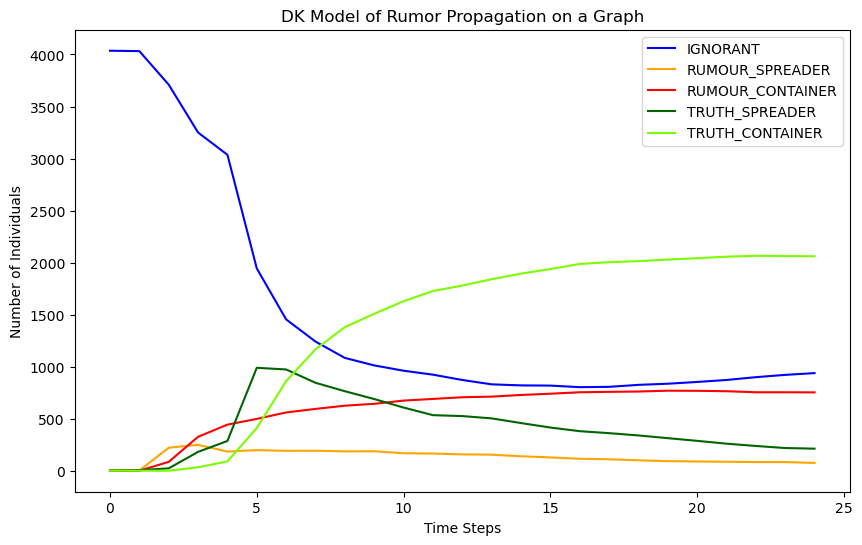

In [22]:
# graph = generate_barabasi_albert_graph(POPULATION_SIZE, CLIQUISHNESS)
graph = generate_facebook_graph()

dk_model = DKModel(graph, initial_rumour_spreaders=1, initial_truth_spreaders=1)
dk_model.run(TIME_STEPS, draw=False)

plt.figure(figsize=(10, 6))
for state in State:
    label = state.name.replace('_', ' ').title()
    plt.plot(dk_model.history[state], label=state.name, color=STATUS_COLOURS[state])
plt.title('DK Model of Rumor Propagation on a Graph')
plt.xlabel('Time Steps')
plt.ylabel('Number of Individuals')
plt.legend()
plt.show()



In [11]:
# Run simulations to get the final rumour/truth sizes and max rumour/truth sizes
TRIALS = 100
final_rumour_sizes = []
final_truth_sizes = []
max_rumour_sizes = []
max_truth_sizes = []

for _ in range(TRIALS):
    dk_model = DKModel(graph, initial_rumour_spreaders=1, initial_truth_spreaders=1)
    dk_model.run(TIME_STEPS)

    final_rumour_sizes.append(dk_model.history[State.RUMOUR_SPREADER][-1] + dk_model.history[State.RUMOUR_CONTAINER][-1])
    final_truth_sizes.append(dk_model.history[State.TRUTH_SPREADER][-1] + dk_model.history[State.TRUTH_CONTAINER][-1])
    max_rumour_sizes.append(max(dk_model.history[State.RUMOUR_SPREADER] + dk_model.history[State.RUMOUR_CONTAINER]))
    max_truth_sizes.append(max(dk_model.history[State.TRUTH_SPREADER] + dk_model.history[State.TRUTH_CONTAINER]))

def display_histogram(data, title):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=20, edgecolor='black')
    plt.title(title)
    plt.xlabel('Number of Individuals')
    plt.ylabel('Frequency')
    plt.show()

display_histogram(final_rumour_sizes, 'Final Rumour Sizes')
display_histogram(final_truth_sizes, 'Final Truth Sizes')
display_histogram(max_rumour_sizes, 'Max Rumour Sizes')
display_histogram(max_truth_sizes, 'Max Truth Sizes')

KeyboardInterrupt: 